In [83]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 10)

# Транзакции

In [84]:
transactions = pd.read_csv("data/transactions.csv.zip")
print(transactions.shape)
transactions.head()

(249353, 5)


,merchant_id,latitude,longitude,real_transaction_dttm,record_date
0,178,0.000000,0.000000,9:34:47,9:30:36
1,178,55.055995,82.912991,17:49:50,17:54:24
2,178,0.000000,0.000000,9:34:47,9:31:22
3,178,55.056034,82.912734,17:49:50,17:43:01
4,178,55.056034,82.912734,17:49:50,17:45:17


Как видно в данных есть 0 у координат - видимо не удалось отправить настоящие координаты. И вот не понятно, это нормальное поведение системы или нет? Нужно ли предсказывать 0 или лучше их все удалить и сделать предсказание внутри тестовых данных? 
Даты real_transaction_dttm и record_date надо бы разбить на час минуту и секунду или просто перевести в число секунд с полуночи.
Предполагаю, что record_date надо заменить на дельту, так как важно спустя какое время данные были внесены, а не когда именно.

In [85]:
transactions.describe() # ну слава Б-гу нет NaN-ов

,merchant_id,latitude,longitude
count,2.493530e+05,249353.000000,249353.000000
mean,4.441047e+05,49.761256,33.758102
std,2.506589e+05,17.722934,17.774541
min,1.780000e+02,-83.445345,-176.155650
25%,3.639860e+05,55.604737,30.382891
50%,4.102950e+05,55.750347,37.594847
75%,5.879220e+05,55.855153,37.661401
max,1.934268e+06,84.830761,171.866882


In [86]:
print(transactions.shape[0])
print(transactions['latitude'].unique().size)
print(transactions['longitude'].unique().size)

249353
75883
76012


In [87]:
def time_to_seconds_since_midnight(time):
    h, m, s = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [88]:
transactions['real_transaction_dttm'] = transactions['real_transaction_dttm'].apply(time_to_seconds_since_midnight)
transactions['record_date'] = transactions['record_date'].apply(time_to_seconds_since_midnight)

In [89]:
transactions['record_delay'] = transactions['record_date'] - transactions['real_transaction_dttm']
transactions.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_date,record_delay
0,178,0.000000,0.000000,34487,34236,-251
1,178,55.055995,82.912991,64190,64464,274
2,178,0.000000,0.000000,34487,34282,-205
3,178,55.056034,82.912734,64190,63781,-409
4,178,55.056034,82.912734,64190,63917,-273


По всей видимости чекины учитываются не только ПОСЛЕ транзакции, но и ДО. Поэтому предлагаю рассматривать абсолютное значение задержки. Это даст куда больше полезной информации. В конце концов не всё ли равно до или после был чекин, главное чтобы максимально близко к моменту транзакции.

In [90]:
transactions[(transactions['latitude'] == 0) | ((transactions['longitude'] == 0))].shape[0]

25028

Из 249353 транзакций 25028 - это пропуски. Пропуски можно оставить как есть, но они будут шуметь. Предлгаю их тоже предсказать первой итерацией алгоритма. Или вообще не учитывать.

In [91]:
transactions['merchant_id'].unique().size

10006

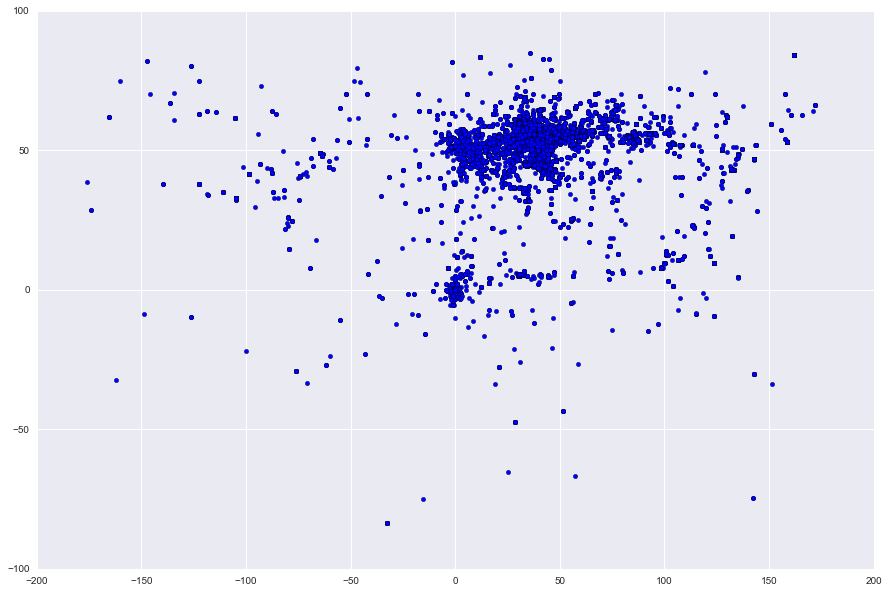

In [92]:
plt.scatter(transactions['longitude'], transactions['latitude'])

Нарисуем график где по оси X - дата транзакции а по Y - дата чекина.
В идеале должна быть диагональ y=x.

Интересно, что есть пара значений ОЧЕНЬ сильно выбивающихся из графика. Вероятно это моменты перехода через сутки, надо бы выровнять!

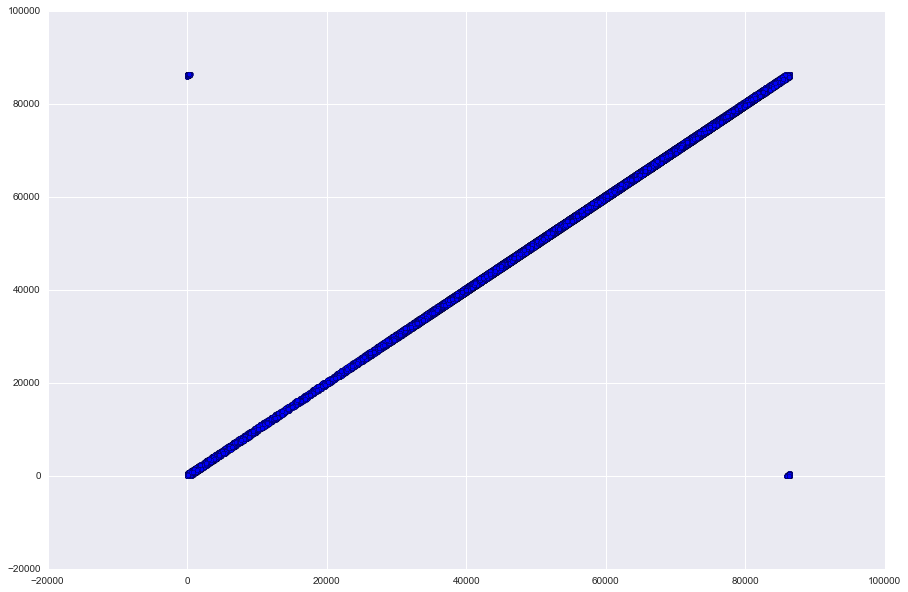

In [43]:
plt.scatter(transactions['real_transaction_dttm'], transactions['record_date'])

In [93]:
# 0.99926 персентиль! Думаю это не помехи, а действительно переход через сутки. Предлгаю погасить его.
transactions['record_delay'].describe(percentiles=[0.99926])

count     249353.000000
mean          -6.825797
std         3125.085890
min       -86384.000000
50%          -27.000000
99.93%     85807.000000
max        86359.000000
Name: record_delay, dtype: float64

In [94]:
for i, row in transactions.iterrows():
    tr_date = row['real_transaction_dttm']
    ch_date = row['record_date']
    if (tr_date - ch_date > 85800):
        transactions.ix[i, 'record_date'] = ch_date + 85800
    elif (ch_date - tr_date > 85800):
        transactions.ix[i, 'real_transaction_dttm'] = tr_date + 85800

In [95]:
# пересчитаем задержки
transactions['record_delay'] = transactions['record_date'] - transactions['real_transaction_dttm']

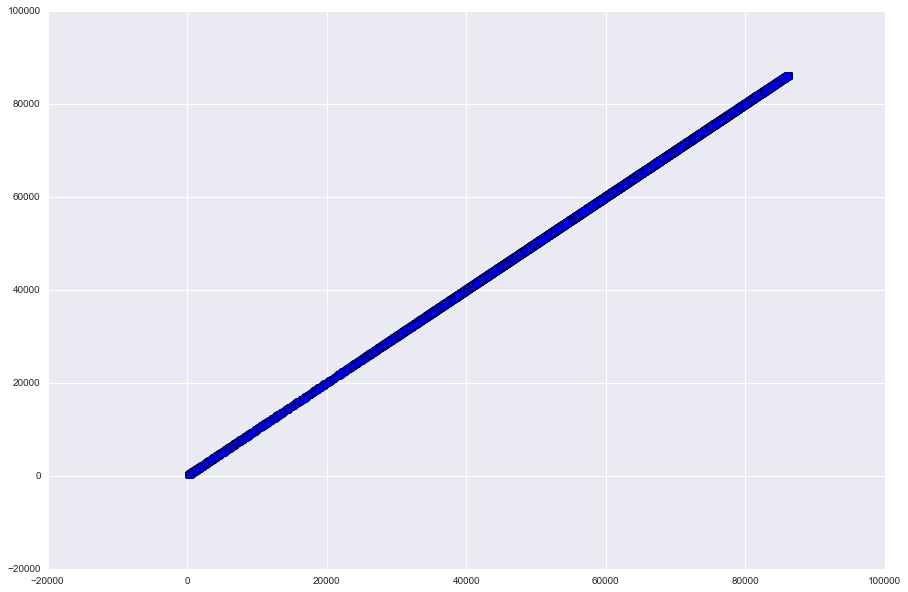

In [96]:
plt.scatter(transactions['real_transaction_dttm'], transactions['record_date'])

In [97]:
transactions['record_delay'].describe(percentiles=[0.99926])

count     249353.000000
mean         -23.342141
std          295.616322
min         -600.000000
50%          -27.000000
99.93%       599.000000
max          600.000000
Name: record_delay, dtype: float64

In [132]:
merch_train = pd.read_csv('data/merchants_train.csv.zip', delimiter=';', index_col='merchant_id')
merch_train.rename(columns={'latitude': 'latitude_origin', 'longitude': 'longitude_origin'}, inplace=True)
print(merch_train.shape)
merch_train.head()

(6482, 2)


,latitude_origin,longitude_origin
merchant_id,,
178,55.055553,82.911833
267,55.726877,37.579645
357,54.706402,20.471420
505,64.553811,40.551964
532,55.768355,49.217176


In [131]:
merch_test = pd.read_csv('data/merchants_test.csv.zip', delimiter=';', index_col='merchant_id')
merch_test.rename(columns={'latitude': 'latitude_origin', 'longitude': 'longitude_origin'}, inplace=True)
print(merch_test.shape)
merch_test.head()

(3524, 2)


,latitude_origin,longitude_origin
merchant_id,,
361,NaN,NaN
428,NaN,NaN
490,NaN,NaN
1175,NaN,NaN
1239,NaN,NaN


Совпадает количество мерчантов - 10006 всего в транзакциях. В train 6482 и в test 3524

In [134]:
merchants = pd.concat([merch_train, merch_test])
merchants.shape

(10006, 2)

In [136]:
all_data = pd.merge(transactions, merchants, left_on='merchant_id', right_index=True)
print(all_data.shape)
all_data.head()

(249353, 8)


,merchant_id,latitude,longitude,real_transaction_dttm,record_date,record_delay,latitude_origin,longitude_origin
0,178,0.000000,0.000000,34487.0,34236.0,-251.0,55.055553,82.911833
1,178,55.055995,82.912991,64190.0,64464.0,274.0,55.055553,82.911833
2,178,0.000000,0.000000,34487.0,34282.0,-205.0,55.055553,82.911833
3,178,55.056034,82.912734,64190.0,63781.0,-409.0,55.055553,82.911833
4,178,55.056034,82.912734,64190.0,63917.0,-273.0,55.055553,82.911833


In [138]:
from geopy.distance import vincenty

def distance(data):
    for i, row in data.iterrows():
        data.ix[i, 'dist'] = vincenty((row['latitude'], row['longitude']), (row['latitude_origin'], row['longitude_origin'])).meters

In [147]:
train = pd.DataFrame(all_data[np.isnan(all_data['latitude_origin']) == False])
train.shape

(166912, 8)

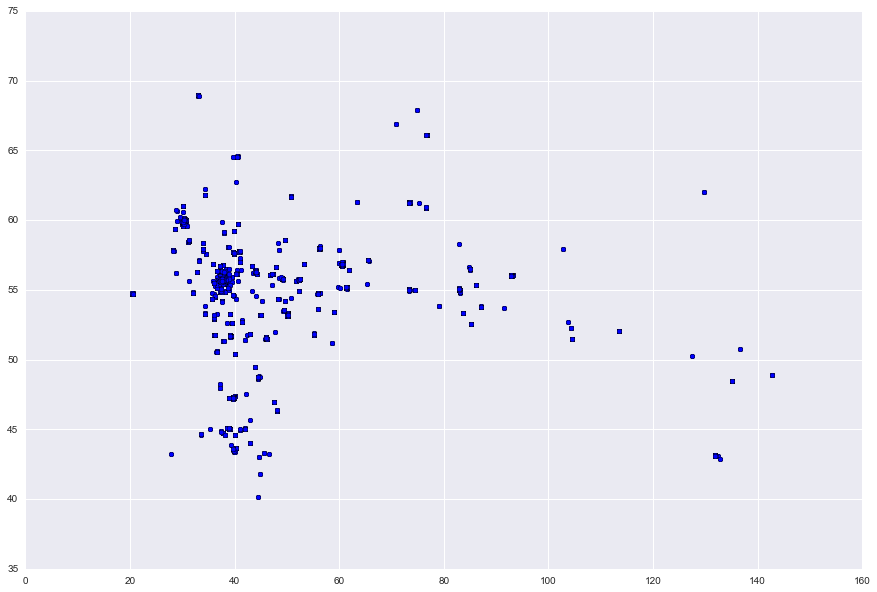

In [152]:
plt.scatter(train['longitude_origin'], train['latitude_origin'])

In [187]:
def draw_coordinates(data):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(data['longitude'], data['latitude'])
    ax.add_patch(plt.Rectangle((20.463191, 40.143636), 142.730432 - 20.463191, 68.970401 - 40.143636, fill=False,hatch='\\'))
    plt.show()

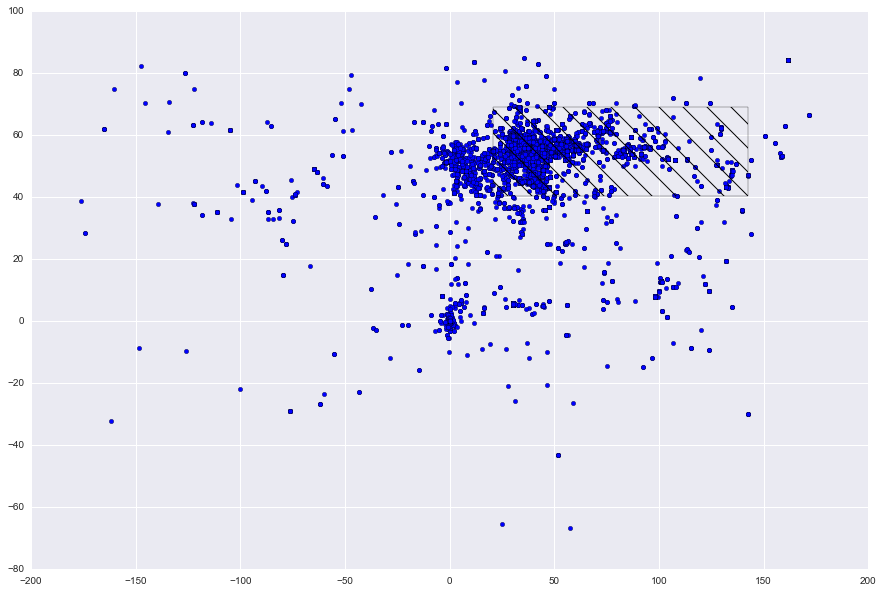

In [188]:
draw_coordinates(train)

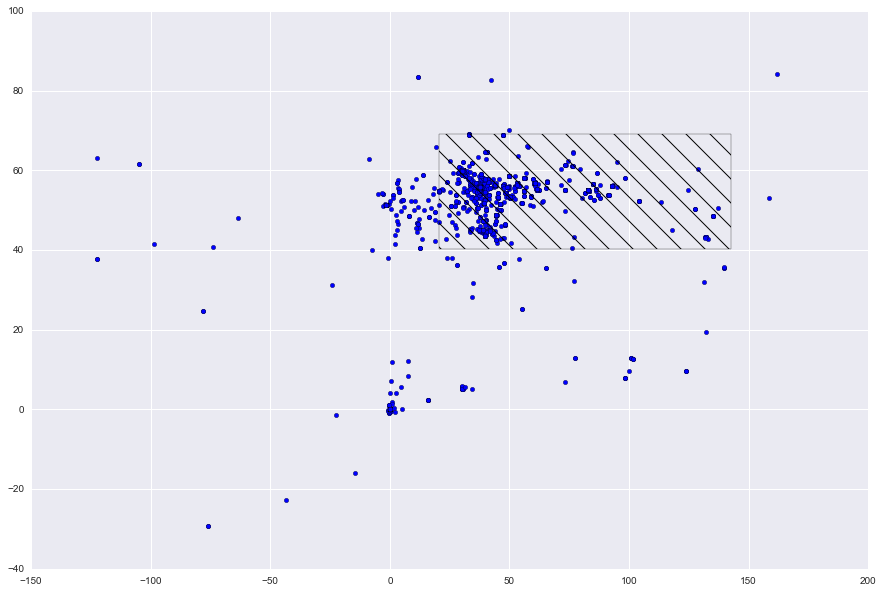

In [195]:
# координаты, задержка в которых между транзакцией и чекином меньше 30 секунд!
# по какой-то неведомой причине, всё равно всё разбросало, вообще
draw_coordinates(train[np.abs(train['record_delay']) < 30])

In [157]:
# Окрестность настоящих координат
print(train['latitude_origin'].min(), train['longitude_origin'].min())
print(train['latitude_origin'].max(), train['longitude_origin'].max())

40.143636 20.463191
68.970401 142.730432


In [158]:
# Окрестность снятых с устройств координат
print(train['latitude'].min(), train['longitude'].min())
print(train['latitude'].max(), train['longitude'].max())

-66.72272191 -176.1556498
84.83076118 171.86688211


Судя по двум графикам выше, с локациями тоже большие проблемы. 
Оригианльные координаты находятся в окрестностях нормально прямоугольника внутри страны.
Снятые координаты  - это точки по всему миру!! Я сначала думал что Нули это большая проблема, но нет. Тут всё еще хуже.

In [148]:
distance(train)
train.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_date,record_delay,latitude_origin,longitude_origin,dist
0,178,0.000000,0.000000,34487.0,34236.0,-251.0,55.055553,82.911833,9.555245e+06
1,178,55.055995,82.912991,64190.0,64464.0,274.0,55.055553,82.911833,8.889887e+01
2,178,0.000000,0.000000,34487.0,34282.0,-205.0,55.055553,82.911833,9.555245e+06
3,178,55.056034,82.912734,64190.0,63781.0,-409.0,55.055553,82.911833,7.866450e+01
4,178,55.056034,82.912734,64190.0,63917.0,-273.0,55.055553,82.911833,7.866450e+01


In [161]:
(train['dist'] // 1000).describe() # минимум - это полное попадание, а максимум - это абсолютно не точно!
# 16993 км!! это вообще что?

count    166912.000000
mean       1073.216180
std        2298.462272
min           0.000000
25%           3.000000
50%          11.000000
75%         633.000000
max       16993.000000
Name: dist, dtype: float64

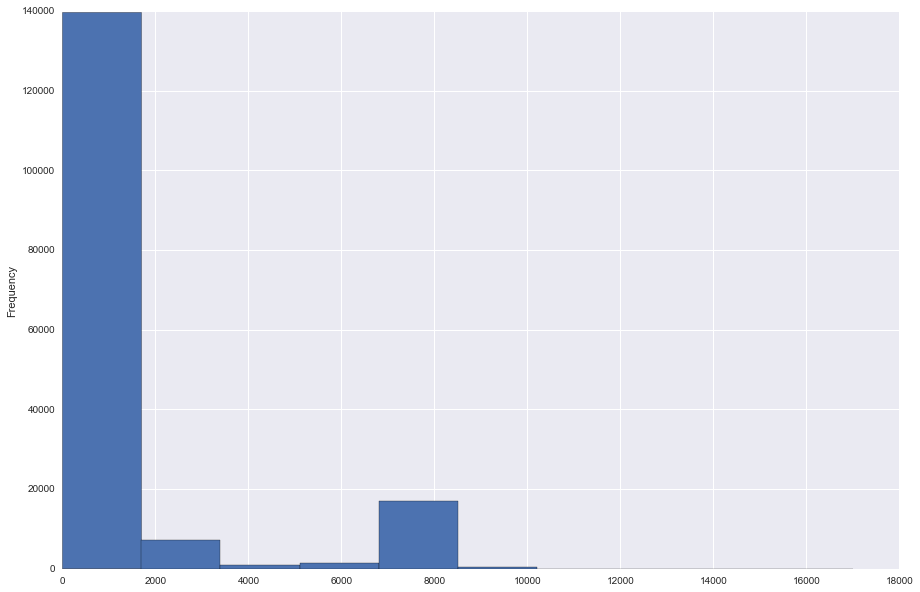

In [172]:
# оценим график расстояний в км между точками.
(train['dist'] // 1000).plot(kind='hist')

На графике очень подозрительные 8000км. Почему именно там такой пик? и на 2000км. Для gps это очень большая погрешность, можно сказать - невозможная.